In [1]:
#!/usr/bin/env python
# -*- coding: UTF-8

# <p style="text-align: center;"> Charter school identities project:<br/> Word Embedding Models with word2vec
<p style="text-align: center;">Creator: Jaren Haber, PhD Candidate<br/>Institution: Department of Sociology, University of California, Berkeley<br/>Date created: July 20, 2018

## Initialize Python

In [13]:
# IMPORTING KEY PACKAGES
import csv # for reading in CSVs and turning them into dictionaries
import re # for regular expressions
import os # for navigating file trees
import nltk # for natural language processing tools
import pandas as pd # for working with dataframes
import numpy as np # for working with numbers
import pickle # For working with .pkl files
from tqdm import tqdm # Shows progress over iterations, including in pandas via "progress_apply"

In [3]:
# FOR CLEANING, TOKENIZING, AND STEMMING THE TEXT
from nltk import word_tokenize, sent_tokenize # widely used text tokenizer
from nltk.stem.porter import PorterStemmer # an approximate method of stemming words (it just cuts off the ends)
from nltk.corpus import stopwords # for eliminating stop words
stopenglish = list(stopwords.words("english")) # assign list of english stopwords
import string # for one method of eliminating punctuation
punctuations = list(string.punctuation) # assign list of common punctuation symbols
punctuations+=['•','©','–'] # Add a few more punctuations also common in web text
import hashlib # For checking for duplicate long strings with minimal memory drain

In [4]:
# FOR ANALYZING THE TEXT
from sklearn.feature_extraction.text import CountVectorizer # to work with document-term matrices, especially
countvec = CountVectorizer(tokenizer=nltk.word_tokenize)
from sklearn.feature_extraction.text import TfidfVectorizer # for creating TF-IDFs
tfidfvec = TfidfVectorizer()
from sklearn.decomposition import LatentDirichletAllocation # for topic modeling

import gensim # for word embedding models
from scipy.spatial.distance import cosine # for cosine similarity
from sklearn.metrics import pairwise # for pairwise similarity
from sklearn.manifold import MDS, TSNE # for multi-dimensional scaling

import Cython # For parallelizing word2vec

In [5]:
# FOR VISUALIZATIONS
import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns # To make matplotlib prettier
sns.set(style='white')
sns.despine()

# Visualization parameters
% pylab inline 
% matplotlib inline
matplotlib.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


## Read in data

In [14]:
# Define file paths
charters_path = "../../charters_full_2015.pkl" # All text data; only charter schools (regardless if open or not)
wem_path = "../data/wem_data.pkl"

In [7]:
# Load charter data into DF
df = pd.read_pickle(charters_path)

In [8]:
# Take a look at the data 
df.head(10)

,CMO_NAME,CMO_MEMSUM,SCH_NAME,CMO_STATE,CMO_SCHNUM,CMO_URL,CMO_NUMSTATES,CMO_ALLSTATES,CMO_SECTOR,CMO_NUMSTUDENTS_CREDO17,...,FTE,YEAR_OPENED,YEAR_CLOSED,SEARCH16,TOTETH,PCTETH,AGE,PCTFRL,PLACE,STR
0,AAEC,1320.0,ARIZONA AGRIBUSINESS & EQUINE CENTER - ESTRELLA,AZ,6.0,https://www.aaechighschools.com/,1.0,AZ,NaN,NaN,...,-1.00,2010.0,NaN,ARIZONA AGRIBUSINESS & EQUINE CENTER - ESTRELL...,239.0,0.497917,5.0,-0.002083,Suburb,-480.000000
1,Arizona Agribusiness & Equine Center,1320.0,ARIZONA AGRIBUSINESS & EQUINE CENTER - ESTRELLA,AZ,6.0,https://www.aaechighschools.com/,1.0,AZ,CMO,1220.0,...,-1.00,2010.0,NaN,ARIZONA AGRIBUSINESS & EQUINE CENTER - ESTRELL...,239.0,0.497917,5.0,-0.002083,Suburb,-480.000000
2,AAEC,1320.0,AAEC - SMCC CAMPUS,AZ,6.0,https://www.aaechighschools.com/,1.0,AZ,NaN,NaN,...,-1.00,2005.0,NaN,"AAEC - SMCC CAMPUS 7050 S. 24th Street , Phoe...",396.0,0.912442,10.0,0.649770,City,-434.000000
3,Arizona Agribusiness & Equine Center,1320.0,AAEC - SMCC CAMPUS,AZ,6.0,https://www.aaechighschools.com/,1.0,AZ,CMO,1220.0,...,-1.00,2005.0,NaN,"AAEC - SMCC CAMPUS 7050 S. 24th Street , Phoe...",396.0,0.912442,10.0,0.649770,City,-434.000000
4,AAEC,1320.0,AAEC - PARADISE VALLEY,AZ,6.0,https://www.aaechighschools.com/,1.0,AZ,NaN,NaN,...,-1.00,1998.0,NaN,AAEC - PARADISE VALLEY 17811 North 32nd Stree...,81.0,0.199507,17.0,-0.002463,City,-406.000000
5,Arizona Agribusiness & Equine Center,1320.0,AAEC - PARADISE VALLEY,AZ,6.0,https://www.aaechighschools.com/,1.0,AZ,CMO,1220.0,...,-1.00,1998.0,NaN,AAEC - PARADISE VALLEY 17811 North 32nd Stree...,81.0,0.199507,17.0,-0.002463,City,-406.000000
6,ACADEMY OF SKILLS AND KNOWLEDGE,1161.0,CUMBERLAND ACADEMY MIDDLE,TX,4.0,http://www.cumberlandacademy.com/,1.0,TX,NaN,NaN,...,40.82,2013.0,NaN,"CUMBERLAND ACADEMY MIDDLE 1040 SHILOH RD , TY...",240.0,0.471513,2.0,0.379175,City,12.469378
7,ACADEMY OF SKILLS AND KNOWLEDGE,1161.0,CUMBERLAND H S,TX,4.0,http://www.cumberlandacademy.com/,1.0,TX,NaN,NaN,...,NaN,2015.0,NaN,"CUMBERLAND H S 7200 PALUXY RD , TYLER TX 7570...",59.0,0.385621,0.0,NaN,Rural,NaN
8,ACADEMY OF SKILLS AND KNOWLEDGE,1161.0,CUMBERLAND ACADEMY,TX,4.0,http://www.cumberlandacademy.com/,1.0,TX,NaN,NaN,...,36.23,1998.0,NaN,"CUMBERLAND ACADEMY 1340 SHILOH RD , TYLER TX ...",217.0,0.434870,17.0,0.408818,City,13.773116
9,ACCELERATED INTERMEDIATE ACADEMY,281.0,ACCELERATED INTERDISCIPLINARY ACAD,TX,3.0,http://www.aiacharterschools.org/,1.0,TX,NaN,NaN,...,16.85,2004.0,NaN,ACCELERATED INTERDISCIPLINARY ACAD 12825 SUMM...,276.0,0.982206,11.0,0.864769,City,16.676558


In [9]:
# Print the webtext from the first school in the dataframe
# Index to first tuple [0] then 4th element [3], which is the webtext
df.iloc[0]["WEBTEXT"][0][3]

"Home\n | \nParent / Student Login \nCall Today!\n602.297.8500\nPrograms\nAcademics\nEquine Studies\nMath & Sciences\nVeterinary & Medical\nOur Schools\nSouth Mountain\nCalendar\nParadise Valley\nCalendar\nRed Mountain\nCalendar\nEstrella Mountain\nCalendar\nPrescott Valley\nCalendar\nMesa\nCalendar\nFor Parents\nStudent Life\nAbout AAEC\nHistory & Philosophy\nGoverning Board\nCommunity Relations\nRegistration\nOther Scholarship Opportunities\nResources\nAccreditation\nSPED\nCareers\nAAEC – In the News\nResource Guides\nPolicies\nFAQ\nBlog\nCommunity Service Events\nAnnual Financial Reports\nPre-Enroll\nContact Us\nBlog\nEstrella Mountain\nAAEC's Estrella Mountain public charter school is an early college high school offering students the opportunity to earn college credits.\nEstrella Mountain\nSafer campuses with small class sizes.\nEstrella Mountain\nLearn from highly qualified teachers. \nEstrella Mountain\nLet your interests guide your education.\nEstrella Mountain\nBe a part of St

## Preprocessing: Tokenize web text by sentences

In [10]:
tqdm.pandas(desc="Preprocessing") # To show progress, create & register new `tqdm` instance with `pandas`

In [11]:
def preprocess_wem(tuplist, start, limit):
    
    '''This function cleans and tokenizes sentences, removing punctuation and numbers and making lower-case.
    Inputs: list of four-element tuples, the last element of which holds the long string of text we care about;
        an integer limit (bypassed when set to -1) indicating the DF row index on which to stop the function (for testing purposes),
        and similarly, an integer start (bypassed when set to -1) indicating the DF row index on which to start the function (for testing purposes).
    This function loops over five nested levels, which from high to low are: row, tuple, chunk, sentence, word.
    Note: This approach maintains accurate semantic distances by keeping stopwords.'''
        
    global words_by_sentence # Grants access to variable holding a list of lists of words, where each list of words represents a sentence in its original order
    global pcount # Grants access to preprocessing counter
    
    # For testing purposes:
    #if limit!=-1 and pcount>int(limit):
    #    return
    #if start!=-1 and pcount<int(start):
    #    return

    known_pages = set() # Initialize list of known pages for a school

    if type(tuplist)==float:
        return # Can't iterate over floats, so exit
    
    for tup in tuplist: # Iterate over tuples in tuplist (list of tuples)
        if tup[3] in known_pages or tup=='': # Could use hashing to speed up comparison: hashlib.sha224(tup[3].encode()).hexdigest()
            continue # Skip this page if exactly the same as a previous page on this school's website

        for chunk in tup[3].split('\n'):
            for sent in sent_tokenize(chunk):
                words_by_sentence.append(list(word.lower() 
                                         for word in word_tokenize(sent) 
                                         if not (word in punctuations 
                                                 or word.isdigit() 
                                                 or word.replace('-','').isdigit() 
                                                 or word.replace('.','').isdigit()
                                                 or word=="'s")))

        known_pages.add(tup[3])
        
    pcount += 1 # Add to counter
    return

In [12]:
words_by_sentence = [] # Initialize variable to hold list of lists of words (sentences)
pcount=0 # Initialize preprocessing counter
df["WEBTEXT"] = df["WEBTEXT"].astype(list) # Coerce these to lists in order to avoid type errors

# Call preprocessing function (with progress monitor) on each DF row's list of text tuples:
df["WEBTEXT"].progress_apply(lambda tups: preprocess_wem(tups, 10, 15))

Preprocessing:   8%|▊         | 865/11521 [15:20<38:00:40, 12.84s/it]

KeyboardInterrupt: 

In [19]:
words_by_sentence

[['home'],
 [],
 ['parent', 'student', 'login'],
 ['call', 'today'],
 [],
 ['programs'],
 ['academics'],
 ['equine', 'studies'],
 ['math', 'sciences'],
 ['veterinary', 'medical'],
 ['our', 'schools'],
 ['south', 'mountain'],
 ['calendar'],
 ['paradise', 'valley'],
 ['calendar'],
 ['red', 'mountain'],
 ['calendar'],
 ['estrella', 'mountain'],
 ['calendar'],
 ['prescott', 'valley'],
 ['calendar'],
 ['mesa'],
 ['calendar'],
 ['for', 'parents'],
 ['student', 'life'],
 ['about', 'aaec'],
 ['history', 'philosophy'],
 ['governing', 'board'],
 ['community', 'relations'],
 ['registration'],
 ['other', 'scholarship', 'opportunities'],
 ['resources'],
 ['accreditation'],
 ['sped'],
 ['careers'],
 ['aaec', 'in', 'the', 'news'],
 ['resource', 'guides'],
 ['policies'],
 ['faq'],
 ['blog'],
 ['community', 'service', 'events'],
 ['annual', 'financial', 'reports'],
 ['pre-enroll'],
 ['contact', 'us'],
 ['blog'],
 ['estrella', 'mountain'],
 ['aaec',
  'estrella',
  'mountain',
  'public',
  'charter',
 

In [20]:
with open(wem_path, 'wb') as destfile:
    pickle.dump(words_by_sentence, destfile)

In [21]:
with open(wem_path, 'rb') as readfile:
    data = pickle.load(readfile)

In [22]:
data

[['home'],
 [],
 ['parent', 'student', 'login'],
 ['call', 'today'],
 [],
 ['programs'],
 ['academics'],
 ['equine', 'studies'],
 ['math', 'sciences'],
 ['veterinary', 'medical'],
 ['our', 'schools'],
 ['south', 'mountain'],
 ['calendar'],
 ['paradise', 'valley'],
 ['calendar'],
 ['red', 'mountain'],
 ['calendar'],
 ['estrella', 'mountain'],
 ['calendar'],
 ['prescott', 'valley'],
 ['calendar'],
 ['mesa'],
 ['calendar'],
 ['for', 'parents'],
 ['student', 'life'],
 ['about', 'aaec'],
 ['history', 'philosophy'],
 ['governing', 'board'],
 ['community', 'relations'],
 ['registration'],
 ['other', 'scholarship', 'opportunities'],
 ['resources'],
 ['accreditation'],
 ['sped'],
 ['careers'],
 ['aaec', 'in', 'the', 'news'],
 ['resource', 'guides'],
 ['policies'],
 ['faq'],
 ['blog'],
 ['community', 'service', 'events'],
 ['annual', 'financial', 'reports'],
 ['pre-enroll'],
 ['contact', 'us'],
 ['blog'],
 ['estrella', 'mountain'],
 ['aaec',
  'estrella',
  'mountain',
  'public',
  'charter',
 

## Word Embeddings with word2vec

### Word2Vec features
<ul>
<li>Size: Number of dimensions for word embedding model</li>
<li>Window: Number of context words to observe in each direction</li>
<li>min_count: Minimum frequency for words included in model</li>
<li>sg (Skip-Gram): '0' indicates CBOW model; '1' indicates Skip-Gram</li>
<li>Alpha: Learning rate (initial); prevents model from over-correcting, enables finer tuning</li>
<li>Iterations: Number of passes through dataset</li>
<li>Batch Size: Number of words to sample from data during each pass</li>
<li>Worker: Set the 'worker' option to ensure reproducibility</li>
</ul>

In [35]:
# train the model, using a minimum of 5 words
model = gensim.models.Word2Vec(words_by_sentence, size=100, window=5, \
                               min_count=2, sg=1, alpha=0.025, iter=5, batch_words=10000, workers=1)

In [36]:
# dictionary of words in model (may not work for old gensim)
# print(len(model.vocab))
# model.vocab

In [37]:
# Find cosine distance between two given word vectors
print(model.similarity('college-prep','align')) # these two are close to essentialism
print(model.similarity('emot', 'curios')) # these two are close to progressivism

0.914012837905
0.934911449012


In [38]:
# create some rough dictionaries for our contrasting educational philosophies
essentialism = ['excel', 'perform', 'prep', 'rigor', 'standard', 'align', 'comprehens', 'content', \
                               'data-driven', 'market', 'research', 'research-bas', 'program', 'standards-bas']
progressivism = ['inquir', 'curios', 'project', 'teamwork', 'social', 'emot', 'reflect', 'creat',\
                'ethic', 'independ', 'discov', 'deep', 'problem-solv', 'natur']

In [39]:
# Let's look at two vectors that demonstrate the binary between these philosophies: align and emot
print(model.most_similar('align')) # words core to essentialism
print()
print(model.most_similar('emot')) # words core to progressivism

[('across', 0.962225079536438), ('common', 0.9599748253822327), ('design', 0.9472075700759888), ('compon', 0.9386098980903625), ('research-bas', 0.9384891986846924), ('sequenc', 0.9361364841461182), ('util', 0.9324259161949158), ('philosophi', 0.9307288527488708), ('exceed', 0.9298505187034607), ('pennsylvania', 0.9288857579231262)]

[('creativ', 0.9845424294471741), ('intellectu', 0.9743475914001465), ('strategi', 0.9633899927139282), ('tool', 0.9565004110336304), ('basic', 0.9564352035522461), ('compet', 0.9557984471321106), ('awar', 0.9557099342346191), ('practic', 0.9553041458129883), ('critic', 0.9519203901290894), ('studentsõ', 0.951266884803772)]


In [40]:
print(model.most_similar('emot')) # words core to progressivism

[('creativ', 0.9845424294471741), ('intellectu', 0.9743475914001465), ('strategi', 0.9633899927139282), ('tool', 0.9565004110336304), ('basic', 0.9564352035522461), ('compet', 0.9557984471321106), ('awar', 0.9557099342346191), ('practic', 0.9553041458129883), ('critic', 0.9519203901290894), ('studentsõ', 0.951266884803772)]


In [41]:
# Let's work with the binary between progressivism vs. essentialism
# first let's find the 50 words closest to each philosophy using the two 14-term dictionaries defined above
prog_words = model.most_similar(progressivism, topn=50)
prog_words = [word for word, similarity in prog_words]
for word in progressivism:
    prog_words.append(word)
print(prog_words[:20])

['deeper', 'acquir', 'appreci', 'disciplin', 'real-world', 'awar', 'cognit', 'trait', 'human', 'mind', 'differenti', 'defin', 'strengthen', 'play', 'authent', 'self-confid', 'show', 'studentsõ', 'explor', 'scientif']


In [42]:
ess_words = model.most_similar(essentialism, topn=50) # now let's get the 50 most similar words for our essentialist dictionary
ess_words = [word for word, similarity in ess_words]
for word in essentialism:
    ess_words.append(word)
print(ess_words[:20])

['acceler', 'blend', 'compon', 'rich', 'intens', 'sequenc', 'infus', 'coursework', 'framework', 'proven', 'college-preparatori', 'across', 'key', 'student-cent', 'fulli', 'industri', 'aim', 'util', 'self-pac', 'profici']


In [43]:
# construct an combined dictionary
phil_words = ess_words + prog_words

In [44]:
# preparing for visualizing this binary with word2vec
x = [model.similarity('emot', word) for word in phil_words]
y = [model.similarity('align', word) for word in phil_words]

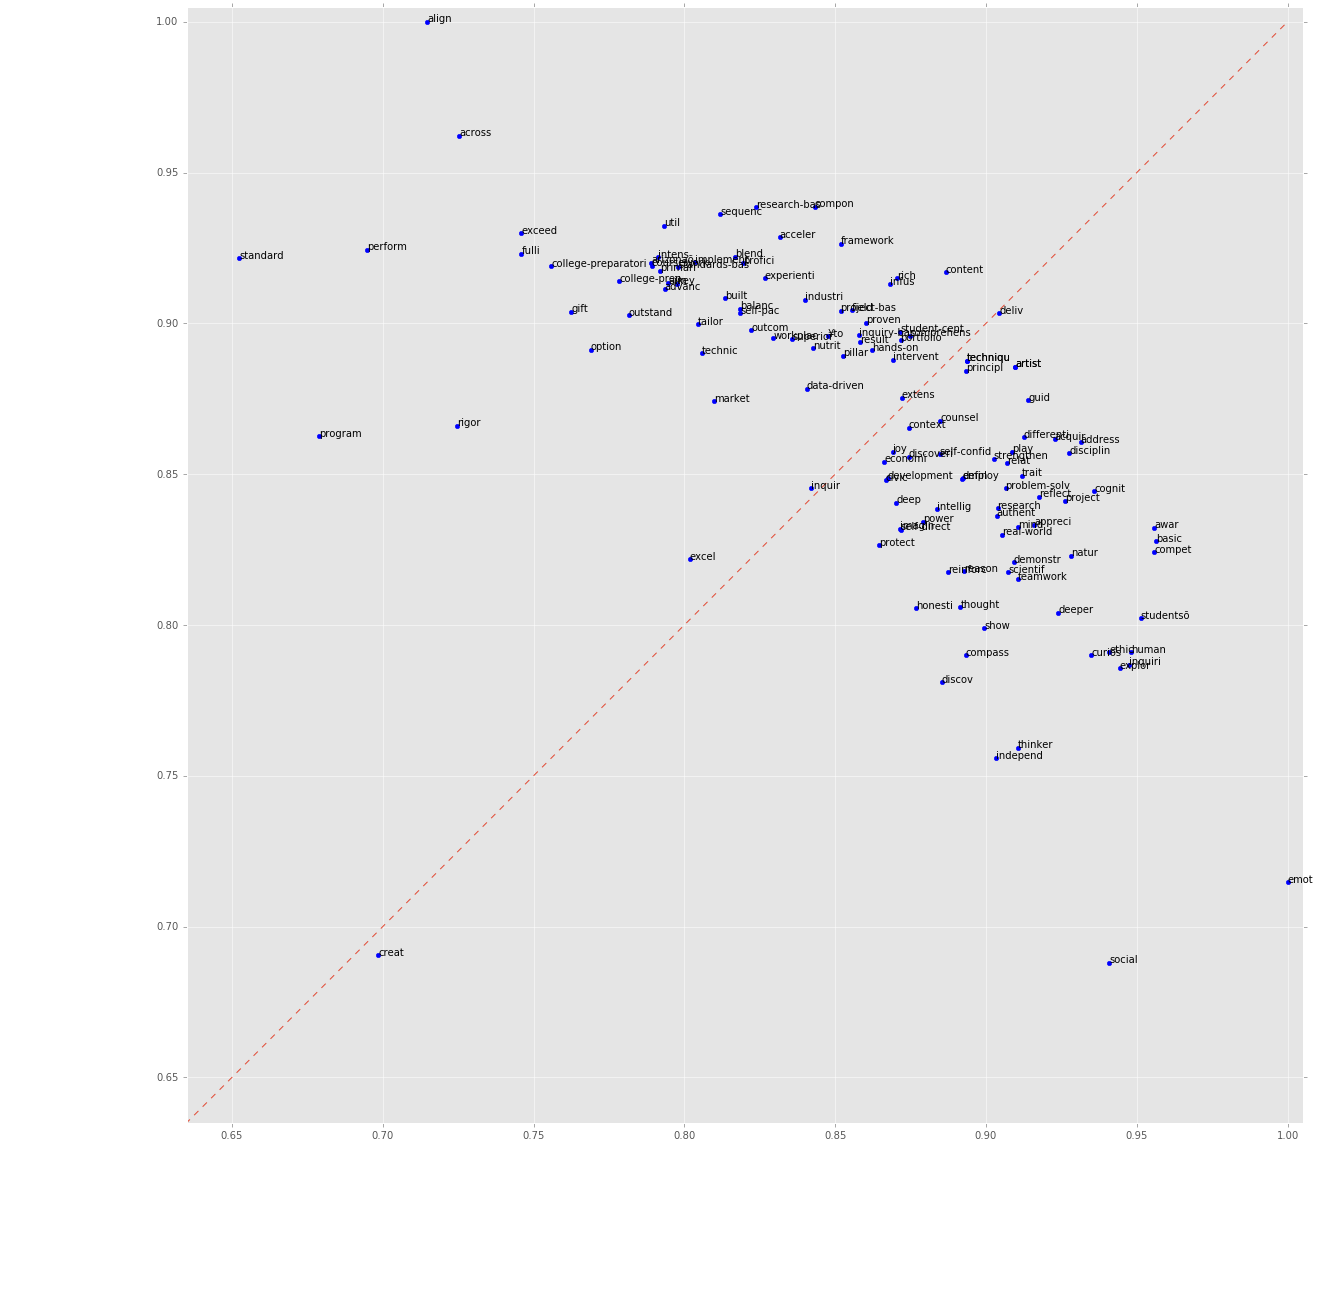

In [45]:
# here's a visual of the progressivism/essentialism binary: 
# top-left half is essentialism, bottom-right half is progressivism
_, ax = plt.subplots(figsize=(20,20))
ax.scatter(x, y, alpha=1, color='b')
for i in range(len(phil_words)):
    ax.annotate(phil_words[i], (x[i], y[i]))
ax.set_xlim(.635, 1.005)
ax.set_ylim(.635, 1.005)
plt.plot([0, 1], [0, 1], linestyle='--');

### Binary of essentialist (top-left) and progressivist (bottom-right) word vectors